In [11]:
import os
import h5py
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score


In [13]:

def get_DMatrix_concat_useevo(VCF_FILE, CHROMATIN_df, CHROMATIN_diff_df, EVO_df):
    # 取子集name
    #rs_name_list = get_rs_name(VCF_FILE)

    # 根据vcf的变异，提取子集，同时依据rs_name顺序，保证提取的特征的顺序与vcf一致，便于比较
    sub_df_ori, sub_diff_df_ori, sub_evo_df_ori = CHROMATIN_df, CHROMATIN_diff_df, EVO_df
    
    print('Chromatin feature df shape: ', sub_df_ori.shape)
    print('Chromatin feature df shape: ', sub_diff_df_ori.shape)
    print('Chromatin evo feature df shape: ', sub_evo_df_ori.shape)

    # 添加label
    sub_df_ori['label'] = np.where(sub_df_ori.name.str.startswith('1000G'), 0, 1)
    sub_diff_df_ori['label'] = np.where(sub_diff_df_ori.name.str.startswith('1000G'), 0, 1)
    # 检查是否有缺失值
    if len(sub_df_ori[sub_df_ori.isnull().values == True]) != 0:
        print('Have NA!')
    if len(sub_diff_df_ori[sub_diff_df_ori.isnull().values == True]) != 0:
        print('Have NA!')
    # 特征提取与label处理
    sub_df = sub_df_ori.iloc[:, 5:]
    sub_diff_df = sub_diff_df_ori.iloc[:, 5:]
    y = np.asarray(sub_df['label'])
    X = np.asarray(sub_df.drop(['label'], axis=1))
    X_diff = np.asarray(sub_diff_df.drop(['label'], axis=1))
    print("X.shape: {}, X_diff.shape: {}, y.shape: {}".format(X.shape, X_diff.shape, y.shape))

    # 标准化处理
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    std_X = ss.fit_transform(X)
    std_X_diff = ss.fit_transform(X_diff)
    print('after standard mean and std is ', np.mean(std_X), np.std(std_X))
    print('after standard mean and std is ', np.mean(std_X_diff), np.std(std_X_diff))

    # 获取该vcf的4个进化保守特征
    sub_evo_df = sub_evo_df_ori.iloc[:, 5:]

    # xgb预处理
    # std_X_hstack = np.hstack((std_X, std_X_diff))
    std_X_hstack = np.hstack((X, X_diff))
    std_X_hstack = np.hstack((std_X_hstack, sub_evo_df))  # 919+919+4
    print(std_X_hstack.shape)
    DM_Xy = xgb.DMatrix(std_X_hstack, y)

    return DM_Xy, std_X, X, y, sub_df_ori, sub_diff_df_ori

## get evolution feature by run_evo.sh

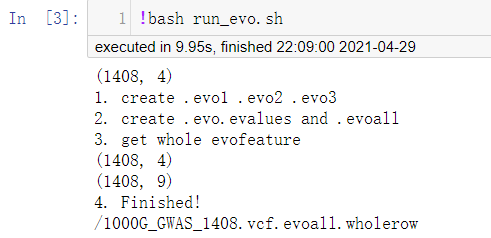

## get chrom feature

In [15]:
import os
os.chdir("/alldata/LChuang_data/workspace/Project/GeneBERT/BGI-Gene_new/examples/vcf-predict")   #to workspace

In [7]:
!bash run_GeneBert_919_2002_3357_3540.sh /alldata/LChuang_data/workspace/Project/GeneBERT/CDTS/1000G_GWAS_1408.vcf 2

Using TensorFlow backend.
2021-04-29 21:59:08.042831: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-04-29 21:59:08.145928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Quadro RTX 6000 major: 7 minor: 5 memoryClockRate(GHz): 1.77
pciBusID: 0000:43:00.0
2021-04-29 21:59:08.146283: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-04-29 21:59:08.148000: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-04-29 21:59:08.149380: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-04-29 21:59:08.149658: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2021-04-29 21:59:08.151180: I tensorflow/s

## LOGO-C2P-predict

In [8]:
import os
os.chdir("/alldata/LChuang_data/workspace/Project/GeneBERT/CDTS")   #

In [9]:
MAIN_PATH = '/alldata/LChuang_data/workspace/Project/GeneBERT/CDTS/'
# evo file path
EVO_df_path = MAIN_PATH + '1000G_GWAS_1408.vcf_output/1000G_GWAS_1408.vcf.evoall.wholerow'
# vcf
VCF_PATH = MAIN_PATH + '1000G_GWAS_1408.vcf'

# output
outputpath = VCF_PATH+'_output/'

In [16]:
weight_path

'/alldata/LChuang_data/workspace/Project/GeneBERT/BGI-Gene_new/examples/HGMD_logistic/XGboost_tri_addevo_feature_nostd/1000G_HGMD_posstrand_8softwares_5_test_shuffle8_XGboost_2002mark_Trible.model'

In [14]:
mark_type_list = [919, 2002]
#mark_type_list = [919, 2002, 3540]
#mark_type_list = [919]

xgboost_path = "/alldata/LChuang_data/workspace/Project/GeneBERT/BGI-Gene_new/examples/HGMD_logistic/XGboost_tri_addevo_feature_nostd/"

for mark_type in mark_type_list:

    print('############ Part1: Getting chromatin feature from {} file ############'.format(mark_type))

    # logfoldchange
    CHROMATIN_FILE = outputpath + os.path.basename(VCF_PATH) + \
                     '_128bs_5gram_{}feature.out.logfoldchange.csv'.format(mark_type)
    CHROMATIN_df = pd.read_csv(CHROMATIN_FILE)  # CHROMATIN_df.head()

    # diff
    CHROMATIN_FILE_diff = outputpath + os.path.basename(VCF_PATH) + \
                          '_128bs_5gram_{}feature.out.diff.csv'.format(mark_type)
    CHROMATIN_diff_df = pd.read_csv(CHROMATIN_FILE_diff)  # CHROMATIN_diff_df.head()

    # evoall
    EVO_df = pd.read_csv(EVO_df_path)  # CHROMATIN_diff_df.head()

    # vcf
    acc_tem_list, AUROC_tem_list = [], []  # storage acc auroc
    for ii in [8]: # THE best weight is index8 weight

        print('############ Part1: Getting DMatrix with {} marks ############'.format(mark_type))
        DM_Xy_test, std_X_test, X_test, y_test, test_df_ori, test_diff_df_ori \
            = get_DMatrix_concat_useevo(VCF_PATH, CHROMATIN_df, CHROMATIN_diff_df, EVO_df)

        print('############ Part2: Getting Xgboost weight with shuffle{} in {} marks ############'.format(ii, mark_type))
        # Training
        #print('Saving model: \n', out_model)
        bst_new = xgb.Booster({'nthread':32}) #init model
        weight_path = xgboost_path + "1000G_HGMD_posstrand_8softwares_5_test_shuffle{}_XGboost_{}mark_Trible.model".format(ii, mark_type)
        bst_new.load_model(weight_path) # load data

        
        # Predicting
        print('############ Part3: Evaluating with {} marks ############'.format(mark_type))
        pred_test_raw = bst_new.predict(DM_Xy_test)
        pred_test_acc = bst_new.predict(DM_Xy_test)
        for i in range(len(pred_test_raw)):
            if pred_test_acc[i] > 0.5:
                pred_test_acc[i] = 1
            else:
                pred_test_acc[i] = 0

        acc_tem = accuracy_score(DM_Xy_test.get_label(), pred_test_acc)
        AUROC_tem = roc_auc_score(DM_Xy_test.get_label(), pred_test_raw)
        print('acc:', acc_tem)
        print('AUROC:', AUROC_tem)
        acc_tem_list.append(acc_tem)
        AUROC_tem_list.append(AUROC_tem)

        # Saving
        print('############ Part5: Saving Xgboost output in {} marks ############'.format(mark_type))
        test_df = test_df_ori.iloc[:, :5]
        test_df['value'] = pred_test_raw
        basename = os.path.basename(VCF_PATH)
        out = outputpath + basename.replace('.vcf','_XGboost_shuffle{}_{}mark_Trible.predict'.format(ii, mark_type))
        if ii == 8:
            test_df.to_csv(out, sep='\t', index=None, header=None)
            print('Saving prediction file: \n', out)

    # 计算10组的平均性能并可视化
    print("np.mean(acc_tem_list), np.mean(AUROC_tem_list) : ", np.mean(acc_tem_list), np.mean(AUROC_tem_list))


############ Part1: Getting chromatin feature from 919 file ############
############ Part1: Getting DMatrix with 919 marks ############
Chromatin feature df shape:  (1408, 924)
Chromatin feature df shape:  (1408, 924)
Chromatin evo feature df shape:  (1408, 9)
X.shape: (1408, 919), X_diff.shape: (1408, 919), y.shape: (1408,)
after standard mean and std is  5.765823404176548e-19 1.0
after standard mean and std is  1.1943491337222849e-19 0.9999999999999999
(1408, 1842)
############ Part2: Getting Xgboost weight with shuffle8 in 919 marks ############
############ Part3: Evaluating with 919 marks ############
acc: 0.7407670454545454
AUROC: 0.8316216587035123
############ Part5: Saving Xgboost output in 919 marks ############
Saving prediction file: 
 /alldata/LChuang_data/workspace/Project/GeneBERT/CDTS/1000G_GWAS_1408.vcf_output/1000G_GWAS_1408_XGboost_shuffle8_919mark_Trible.predict
np.mean(acc_tem_list), np.mean(AUROC_tem_list) :  0.7407670454545454 0.8316216587035123
############ Par

In [69]:

mark_type_list = [919, 2002, 3540]
#mark_type_list = [919]

xgboost_path = "/alldata/LChuang_data/workspace/Project/GeneBERT/BGI-Gene_new/examples/HGMD_logistic/XGboost_tri_addevo_feature_nostd/"

for mark_type in mark_type_list:

    print('############ Part1: Getting chromatin feature from {} file ############'.format(mark_type))

    # logfoldchange
    CHROMATIN_FILE = outputpath + os.path.basename(VCF_PATH) + \
                     '_128bs_5gram_{}feature.out.logfoldchange.csv'.format(mark_type)
    CHROMATIN_df = pd.read_csv(CHROMATIN_FILE)  # CHROMATIN_df.head()

    # diff
    CHROMATIN_FILE_diff = outputpath + os.path.basename(VCF_PATH) + \
                          '_128bs_5gram_{}feature.out.diff.csv'.format(mark_type)
    CHROMATIN_diff_df = pd.read_csv(CHROMATIN_FILE_diff)  # CHROMATIN_diff_df.head()

    # evoall
    EVO_df = pd.read_csv(EVO_df_path)  # CHROMATIN_diff_df.head()

    # vcf
    acc_tem_list, AUROC_tem_list = [], []  # storage acc auroc
    for ii in [8]:  # THE best weight is index8 weight

        print('############ Part1: Getting DMatrix with {} marks ############'.format(mark_type))
        DM_Xy_test, std_X_test, X_test, y_test, test_df_ori, test_diff_df_ori \
            = get_DMatrix_concat_useevo(VCF_PATH, CHROMATIN_df, CHROMATIN_diff_df, EVO_df)

        print('############ Part2: Getting Xgboost weight with shuffle{} in {} marks ############'.format(ii, mark_type))
        # Training
        #print('Saving model: \n', out_model)
        bst_new = xgb.Booster({'nthread':32}) #init model
        weight_path = xgboost_path + "1000G_HGMD_posstrand_8softwares_5_test_shuffle{}_XGboost_{}mark_Trible.model".format(ii, mark_type)
        bst_new.load_model(weight_path) # load data

        
        # Predicting
        print('############ Part3: Evaluating with {} marks ############'.format(mark_type))
        pred_test_raw = bst_new.predict(DM_Xy_test)
        pred_test_acc = bst_new.predict(DM_Xy_test)
        for i in range(len(pred_test_raw)):
            if pred_test_acc[i] > 0.5:
                pred_test_acc[i] = 1
            else:
                pred_test_acc[i] = 0

        acc_tem = accuracy_score(DM_Xy_test.get_label(), pred_test_acc)
        AUROC_tem = roc_auc_score(DM_Xy_test.get_label(), pred_test_raw)
        print('acc:', acc_tem)
        print('AUROC:', AUROC_tem)
        acc_tem_list.append(acc_tem)
        AUROC_tem_list.append(AUROC_tem)

        # Saving
        print('############ Part5: Saving Xgboost output in {} marks ############'.format(mark_type))
        test_df = test_df_ori.iloc[:, :5]
        test_df['value'] = pred_test_raw
        basename = os.path.basename(VCF_PATH)
        out = outputpath + basename.replace('.vcf','_XGboost_shuffle{}_{}mark_Trible.predict'.format(ii, mark_type))
        if ii == 8:
            test_df.to_csv(out, sep='\t', index=None, header=None)
            print('Saving prediction file: \n', out)

    # 计算10组的平均性能并可视化
    print("np.mean(acc_tem_list), np.mean(AUROC_tem_list) : ", np.mean(acc_tem_list), np.mean(AUROC_tem_list))


############ Part1: Getting chromatin feature from 919 file ############
############ Part1: Getting DMatrix with 919 marks ############
Chromatin feature df shape:  (1408, 924)
Chromatin feature df shape:  (1408, 924)
Chromatin evo feature df shape:  (1408, 9)
X.shape: (1408, 919), X_diff.shape: (1408, 919), y.shape: (1408,)
after standard mean and std is  5.765823404176548e-19 1.0
after standard mean and std is  1.1943491337222849e-19 0.9999999999999999
(1408, 1842)
############ Part2: Getting Xgboost weight with shuffle8 in 919 marks ############
############ Part3: Evaluating with 919 marks ############
acc: 0.7407670454545454
AUROC: 0.8316216587035123
############ Part5: Saving Xgboost output in 919 marks ############
Saving prediction file: 
 /alldata/LChuang_data/workspace/Project/GeneBERT/CDTS/1000G_gwas_5_rm1000ginhgmdtrainset_balance.vcf_output/1000G_gwas_5_rm1000ginhgmdtrainset_balance_XGboost_shuffle8_919mark_Trible.predict
np.mean(acc_tem_list), np.mean(AUROC_tem_list) :  